In [1]:
import habitat

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from habitat.tasks.nav.shortest_path_follower import ShortestPathFollower
from PIL import Image
import uuid
import os
import shutil
from typing import Any
import quaternion
import random
from env import Env
from utils import draw_top_down_map, AgentPosition

In [4]:
config = habitat.get_config("/root/Vetlin/mask-r-cnn/challenge_objectnav2020.local.rgbd.yaml")

config.defrost()

config.DATASET.DATA_PATH = "/data/datasets/objectnav/mp3d/v1/{split}/{split}.json.gz"
config.DATASET.SCENES_DIR = "/data/scene_datasets"
config.DATASET.SPLIT = "train"

config.SIMULATOR.HABITAT_SIM_V0.ALLOW_SLIDING = True
config.SIMULATOR.RGB_SENSOR.NOISE_MODEL_KWARGS.intensity_constant = 0.01
config.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER = 0.0

H = 320
W = 640

config.SIMULATOR.RGB_SENSOR.HEIGHT = H
config.SIMULATOR.RGB_SENSOR.WIDTH = W
config.SIMULATOR.DEPTH_SENSOR.HEIGHT = H
config.SIMULATOR.DEPTH_SENSOR.WIDTH = W
config.SIMULATOR.SEMANTIC_SENSOR.HEIGHT = H
config.SIMULATOR.SEMANTIC_SENSOR.WIDTH = W

config.PYROBOT.RGB_SENSOR.HEIGHT = H
config.PYROBOT.RGB_SENSOR.WIDTH = W
config.PYROBOT.DEPTH_SENSOR.HEIGHT = H
config.PYROBOT.DEPTH_SENSOR.WIDTH = W

config.SIMULATOR.HABITAT_SIM_V0.ALLOW_SLIDING = True

config.SIMULATOR.AGENT_0.SENSORS.append('SEMANTIC_SENSOR')

config.SIMULATOR.TURN_ANGLE = 5
config.SIMULATOR.TILT_ANGLE = 5
config.SIMULATOR.FORWARD_STEP_SIZE = 0.15

config.TASK.MEASUREMENTS.append("TOP_DOWN_MAP")
config.TASK.SENSORS.append("HEADING_SENSOR")
config.TASK.SENSORS.append("GPS_SENSOR")
config.TASK.GPS_SENSOR.DIMENSIONALITY = 2
config.TASK.GPS_SENSOR.GOAL_FORMAT = "CARTESIAN"

config.TASK.AGENT_POSITION_SENSOR = habitat.Config()
config.TASK.AGENT_POSITION_SENSOR.TYPE = "my_supercool_sensor"
config.TASK.AGENT_POSITION_SENSOR.ANSWER_TO_LIFE = 42
config.TASK.SENSORS.append("AGENT_POSITION_SENSOR")

config.freeze()

In [5]:
env = Env(config)

2020-07-07 12:30:44,644 Initializing dataset ObjectNav-v1
Initializing dataset ObjectNav-v1
2020-07-07 12:34:39,297 initializing sim Sim-v0
initializing sim Sim-v0
2020-07-07 12:34:42,761 Initializing task ObjectNav-v1
Initializing task ObjectNav-v1
The answer to life is 42


In [6]:
DATASET_DIRECTORY_X = '/root/Vetlin/X'
DATASET_DIRECTORY_Y = '/root/Vetlin/Y'
if os.path.exists(DATASET_DIRECTORY_X):
    shutil.rmtree(DATASET_DIRECTORY_X)
    shutil.rmtree(DATASET_DIRECTORY_Y)
os.makedirs(DATASET_DIRECTORY_X)
os.makedirs(DATASET_DIRECTORY_Y)

In [7]:
def prepare_semantic_observation(observations):
    scene = env.sim.semantic_annotations()
    instance_id_to_label_id = {int(obj.id.split("_")[-1]): obj.category.index() for obj in scene.objects}
    mapping = np.array([ instance_id_to_label_id[i] for i in range(len(instance_id_to_label_id)) ])

    return np.take(mapping, observations['semantic'])

In [8]:
observations, info, done = env.reset()

In [9]:
index_to_title_map2 = {i.category.index(): i.category.name() for i in env.sim.semantic_annotations().objects}
index_to_title_map2[-1] = 'nope'
print(len(index_to_title_map2))
print(index_to_title_map2)

31
{1: 'wall', 17: 'ceiling', 40: 'misc', 12: 'curtain', 0: 'void', 11: 'bed', 22: 'tv_monitor', -1: 'nope', 13: 'chest_of_drawers', 8: 'cushion', 2: 'floor', 28: 'lighting', 5: 'table', 4: 'door', 20: 'towel', 23: 'shower', 15: 'sink', 21: 'mirror', 38: 'clothes', 39: 'objects', 19: 'stool', 18: 'toilet', 7: 'cabinet', 26: 'counter', 10: 'sofa', 32: 'blinds', 36: 'furniture', 3: 'chair', 6: 'picture', 31: 'shelving', 37: 'appliances'}


In [10]:
def save_image_for_dataset(observations):
    rgb = observations['rgb']
    
    image = Image.fromarray(rgb)
    u = uuid.uuid1()
    
    image.save(DATASET_DIRECTORY_X + "/" + str(u) + '.png')
    
#     semantic = prepare_semantic_observation(observations)
    semantic = observations['semantic']
    
    unique_values = np.unique(semantic)
       
    objects = []
    
    os.mkdir(DATASET_DIRECTORY_Y + "/" + str(u))
    
    for value in unique_values:
        obj = (semantic == value)
        
        scene = env.sim.semantic_annotations()
        instance_id_to_label_id = {int(obj.id.split("_")[-1]): obj.category.index() for obj in scene.objects}
        
        title = str(instance_id_to_label_id[value])
        
        image = Image.fromarray(obj)
        image.save(DATASET_DIRECTORY_Y + "/" + str(u) + "/" + title + ".png")

In [11]:
scene = env.sim.semantic_annotations()
instance_id_to_label_id = {int(obj.id.split("_")[-1]): obj.category.index() for obj in scene.objects}

In [12]:
print(len(np.array([ instance_id_to_label_id[i] for i in range(len(instance_id_to_label_id)) ])))
np.array([ instance_id_to_label_id[i] for i in range(len(instance_id_to_label_id)) ])

187


array([ 1, 17, 40, 12,  0, 11,  0, 22, -1, 13,  8, 13,  2, 40, 28, 11,  8,
        0,  8,  5, 28,  8,  8,  2,  4, 20, 23, 20, 15,  1, 40,  5, 21, 21,
       38, 17, 40, 20, 21, 39, 39, 19, 20, 28, 20, 39, 39, 20, 40, 20, 28,
       23,  2,  1, 18, 40,  4,  2, 17, 40, 39, 28,  7, 26,  1, 17,  2, 21,
        4,  7, 18, 15, 39, 28, 26, 39, 20, 20, 40, 39, 39, 40,  1, 28,  4,
        8, 10, 22,  4,  8,  2, 32, 36, 17, 39,  1, 12, 39, 17,  3,  2,  6,
        3, 40,  3,  3, 28,  3,  3, 22,  3, 39,  3, 28, 39,  1,  4,  4, 17,
        4,  2, 21, 40, 28,  0,  1, 17, 12,  0,  0, 10,  8,  5,  0,  0, 22,
       40,  2,  0,  8,  0,  3,  0,  8,  8,  0,  6,  0,  0,  8, 28,  0,  3,
       12,  2,  1,  2,  3,  5, 17,  6,  6, 40, 28,  6,  8,  4,  8,  8,  8,
       28,  1, 39, 26, 40,  7, 31, 37, 17, 37, 19, 19, 19,  2, 26, 31, 15])

In [13]:
prepare_semantic_observation(observations)

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]])

In [14]:
save_image_for_dataset(observations)

In [15]:
def check_action(cur_action, last_action, is_bump):
    if is_bump and cur_action == 'MOVE_FORWARD':
        return False
    
    if cur_action == 'TURN_LEFT' and last_action == 'TURN_RIGHT':
        return False
    if cur_action == 'TURN_RIGHT' and last_action == 'TURN_LEFT':
        return False

    return True

In [16]:
def get_random_action(last, is_bump):
    action = random.choice(list(action_mapping))

    while not(check_action(action, last, is_bump)):
        action = random.choice(list(action_mapping))

    return action

In [17]:
class Saver:
    def __init__(self):
        self.count = 0
        self.path = 'images'
        self.all_positions = {}
        
    def save_image(self, observations, env):
        cur_scene = env.current_episode.scene_id
        
        if self.check_exist_image(observations, cur_scene):
            return;

        save_image_for_dataset(observations)

        self.count += 1
        scene = env.sim.semantic_annotations()
        if cur_scene in self.all_positions:
            self.all_positions[cur_scene] = np.append(self.all_positions[cur_scene], [observations['agent_position']], axis=0)
        else:
            self.all_positions[cur_scene] = np.array([observations['agent_position']])
        
    def check_exist_image(self, observations, cur_scene):
        cur_position = observations['agent_position']
        
        if not(cur_scene in self.all_positions):
            return False
        
        min_diff = np.sqrt(np.square(self.all_positions[cur_scene] - cur_position).sum(axis=1).min())
        
        return min_diff <= 2

In [18]:
def check_bump(last_observations, observations):
    return np.sqrt(np.square(last_observations['agent_position'] - observations['agent_position']).sum()) <= 0.5

In [19]:
action_mapping = {
    1: 'MOVE_FORWARD',
    2: 'TURN_LEFT',
    3: 'TURN_RIGHT'
}

In [20]:
saver = Saver()

index = 0
ii=0
done = False
mapper = []
maps = []


for i in range(len(env.episodes)):
    
    observations, info, done = env.reset()
    
    mapper.append(observations['objectgoal'][0])

    last = ''
    is_bump = False

    while not done:
        
        action = 0

        last_observations = observations
        
        observations, info, done = env.step(action,ideal_action=True)

        is_bump = check_bump(last_observations, observations)
            
        index += 1

        saver.save_image(observations, env)
    
    ii+=1
    top_down_map = draw_top_down_map(info, observations["heading"][0], observations['rgb'][0].shape[0])
    maps.append(top_down_map)
    print(ii,'\t',index)
    
    if index >= 100000:
        break

1 	 500
2 	 1000
3 	 1500
4 	 2000
5 	 2500
6 	 3000
7 	 3500
8 	 4000
9 	 4500
10 	 5000
11 	 5500
12 	 6000
13 	 6500
14 	 7000
15 	 7500
16 	 8000
17 	 8500
18 	 9000
19 	 9500
20 	 10000
21 	 10500
22 	 11000
23 	 11500
24 	 12000
25 	 12500
26 	 13000
27 	 13500
28 	 14000
29 	 14028
30 	 14528
31 	 15028
32 	 15528
33 	 16028
34 	 16155
35 	 16655
36 	 17155
37 	 17655
38 	 18155
39 	 18235
40 	 18735
41 	 19235
42 	 19735
43 	 19791
44 	 19969
45 	 20043
46 	 20418
47 	 20564
48 	 20839
49 	 21134
50 	 21253
51 	 21320
52 	 21669
53 	 21788
54 	 21935
55 	 22315
56 	 22419
57 	 22621
58 	 22717
59 	 23088
60 	 23150
61 	 23243
62 	 23404
63 	 23779
64 	 23907
65 	 24010
66 	 24205
67 	 24298
68 	 24424
69 	 24515
70 	 24844
71 	 25045
72 	 25409
73 	 25673
74 	 25817
75 	 26102
76 	 26226
77 	 26416
78 	 26512
79 	 26701
80 	 26796
81 	 27151
82 	 27220
83 	 27320
84 	 27371
85 	 27493
86 	 27657
87 	 27728
88 	 27888
89 	 28033
90 	 28222
91 	 28293
92 	 28378
93 	 28501
94 	 2

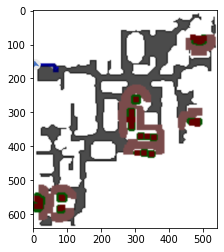

In [25]:
if os.path.exists('/root/Vetlin/dataset_maps'):
    shutil.rmtree('/root/Vetlin/dataset_maps')
os.makedirs('/root/Vetlin/dataset_maps')
i = 0
for mapp in maps:
    plt.imshow(mapp)
    plt.savefig('/root/Vetlin/dataset_maps/map_{}.png'.format(i))
    i+=1

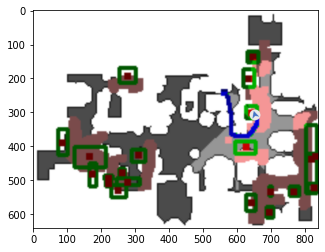

In [23]:
plt.imshow(maps[100])

In [197]:
saver.all_positions

{'/data/scene_datasets/mp3d/1pXnuDYAj8r/1pXnuDYAj8r.glb': array([[ 46.73971939,   7.65658712, -11.57059956,   5.65077531,
          10.5862534 ],
        [ 45.60383987,   7.65658712, -11.18358707,   7.40321016,
           9.44417739],
        [ 43.85590363,   7.56996918, -10.7537756 ,   8.19815326,
           8.76300716],
        ...,
        [ 46.44364166,   7.51871204,  -8.64507961,  -9.40388989,
          -7.45431805],
        [ 38.05192184,   0.45658684,   4.6487999 ,  -0.05048405,
          11.99989414],
        [ 36.09735107,   0.45658684,  10.31934357,   3.56028986,
          11.45968294]]),
 '/data/scene_datasets/mp3d/29hnd4uzFmX/29hnd4uzFmX.glb': array([[-29.72719955,  -0.83583492,  -2.98912001,  -4.97245538,
          10.92129564],
        [-29.72719955,  -0.83583492,  -2.98912001,  -6.79337597,
           9.89191818],
        [-29.72719955,  -0.83583492,  -2.98912001,  -8.40788341,
           8.56198096],
        ...,
        [-13.03827953,  -0.83583492, -15.99812031,  -2.89

In [198]:
scene = env.sim.semantic_annotations()
instance_id_to_label_id = {int(obj.id.split("_")[-1]): obj.category.index() for obj in scene.objects}
print(len(np.array([ instance_id_to_label_id[i] for i in range(len(instance_id_to_label_id)) ])))
np.array([ instance_id_to_label_id[i] for i in range(len(instance_id_to_label_id)) ])

327


array([17,  1, 12,  2, 40, 12, 12,  1, 12, 24, 28,  1, 12,  9, 12,  4,  1,
        9,  9, 24,  9,  9, 28, 24, -1,  1, 28,  9,  9,  7,  7,  5, 10,  3,
        3, 10, 39, 10, 10,  3, 10,  3,  3,  5, 10,  3,  3, 39, 10, 10,  5,
        5,  3,  5,  5,  3,  5, 19,  2, 17,  1,  1,  3, 28,  9,  9, 40,  1,
        4,  1,  1,  4,  4,  4,  4,  1,  4,  4, 30,  4,  4,  4,  4,  9,  6,
        1, 30,  2, 28,  3,  1, 17, 24, 40, 28, 31, 16,  4,  1,  1,  4, 17,
        1,  5,  1,  1, 39,  9, 39, 39,  4, 39, 12, 40,  3, 39, 39, 28,  2,
       28, 39, 28, 39,  1,  3, 17, 17,  3,  4,  3,  3,  2,  9,  4,  3,  9,
        3,  3, 40,  3,  3,  3,  5,  3,  5,  9,  9,  3,  3,  3,  5,  4,  3,
        5,  3,  5,  3,  3,  3,  9,  3,  3,  3,  3,  3,  9,  5,  3,  5,  4,
        3,  3,  3,  3,  3,  5,  3,  3,  5,  3, 17,  1, 40,  3,  3,  1,  3,
        5,  1,  2,  3,  3, 12,  1,  5,  5,  3,  3,  3,  4,  3,  3,  5,  3,
        3,  3,  4,  3, 12,  3,  3, 12,  3,  3,  3,  3, 12,  3,  3,  3,  3,
        3,  5,  3,  3,  5

In [1]:
len(mapper)

NameError: name 'mapper' is not defined

In [27]:
observations, info, done = env.reset()
observations, info, done = env.step(0,ideal_action=True)

In [31]:
observations['semantic']

array([[31, 31, 31, ..., 31, 31, 31],
       [31, 31, 31, ..., 31, 31, 31],
       [31, 31, 31, ..., 31, 31, 31],
       ...,
       [31, 31, 31, ..., 31, 31, 31],
       [31, 31, 31, ..., 31, 31, 31],
       [31, 31, 31, ..., 31, 31, 31]], dtype=uint32)

In [100]:
for i in range(10):
    observations, info, done = env.step(0,ideal_action=True)
    print(done)

False
False
False
False
False
False
False
False
False
False


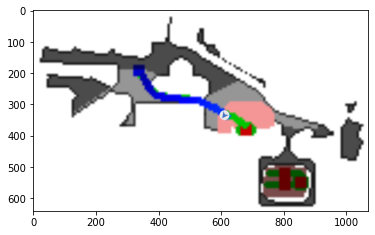

In [101]:
top_down_map = draw_top_down_map(info, observations["heading"][0], observations['rgb'][0].shape[0])
plt.imshow(top_down_map)

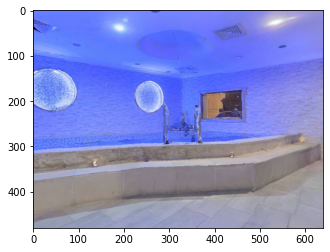

In [57]:
plt.imshow(observations['rgb'])

In [104]:
env._sim.get_agent_state(0).position

array([-0.27891853,  0.26262647,  0.41564366], dtype=float32)

In [102]:
env._current_episode.goals[0].position

[-0.91688, 0.17111, 1.49826]

In [68]:
env._sim.get_agent_state(0).position

array([ 1.2418535,  0.6844127, -2.9903193], dtype=float32)

In [56]:
kek = observations['rgb'].reshape([320, 240, -1])

In [60]:
kek.shape
img = Image.fromarray(kek)

TypeError: Cannot handle this data type: (1, 1, 12), |u1